# Model without spatio temporal features

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install talos

  Using cached https://files.pythonhosted.org/packages/de/f0/96fb2e0412ae9692dbf400e5b04432885f677ad6241c088ccc5fe7724d69/tensorflow-1.14.0-cp36-cp36m-manylinux1_x86_64.whl


In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

  Using cached https://files.pythonhosted.org/packages/2b/53/e18c5e7a2263d3581a979645a185804782e59b8e13f42b9c3c3cfb5bb503/tensorflow_gpu-2.0.0b1-cp36-cp36m-manylinux1_x86_64.whl


In [0]:
%matplotlib inline
%tensorflow_version 2.x

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import talos

from time import time
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, LSTM, Embedding, Input, Concatenate
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from sklearn import preprocessing

import os, sys
import string

from collections import Counter

from python_utils import *

Using TensorFlow backend.


In [0]:
#loading the dataset
df = pd.read_csv("/content/drive/My Drive/26_5_Final-Merged-File.csv", encoding='utf-8')

In [0]:
#dataframe without spatial and temporal information
df_nc = df[['title ', 'text', 'URL', 'label']]

In [0]:
df_nc.head(1)

,title,text,URL,label
0,A video shows a fortune teller predicting the...,Circulating on social networks a video that sh...,https://observador.pt/factchecks/fact-check-um...,FALSE


# Data preprocessing

In [0]:
pd.set_option('display.max_colwidth', -1)
df_nc.columns
#needed are title, text, label, URL

Index(['title ', 'text', 'URL', 'label'], dtype='object')

In [0]:
df_nc.count()

title     2901
text      2894
URL       2901
label     2901
dtype: int64

In [0]:
df_nc.label.unique()

array(['FALSE', 'Pants on Fire!', 'misleading', 'Explanatory',
       'Partly false', 'Mostly False', 'PARTLY FALSE', 'MISLEADING',
       'Misleading', 'No Evidence', 'Mainly false', 'Mostly false',
       'No evidence', 'Partially false', 'Misleading/False',
       'MOSTLY TRUE', 'Partly true', 'false and misleading', 'HALF TRUE',
       'Mostly True', "(Org. doesn't apply rating)", 'Fake', 'Correct',
       'Unlikely', 'Conspiracy theory', 'Partially true', 'Not true',
       'Half True', 'MOSTLY FALSE', 'PARTLY TRUE', 'TRUE', nan],
      dtype=object)

In [0]:
#converting our problem into a binary classification problem
df_nc['label'] = df_nc['label'].replace({
                                        'FALSE' : 'False',
                                        'Pants on Fire!' : 'False', 
                                        'misleading': 'False',
                                        'Partly false' : 'False',
                                        'Mostly False' : 'False',
                                        'PARTLY FALSE' : 'False',
                                        'MISLEADING' : 'False',
                                        'Misleading' : 'False',
                                        'Mainly false' : 'False',
                                        'Mostly false' : 'False',
                                        'Partially false' : 'False',
                                        'Misleading/False' : 'False',
                                        'false and misleading' : 'False',
                                        'Fake' : 'False',
                                        'Unlikely' : 'False',
                                        'Not true' : 'False',
                                        'MOSTLY FALSE' : 'False',
                                        'Conspiracy theory' : 'False',
                                        'MOSTLY TRUE' : 'True',
                                        'Partly true' : 'True',
                                        'Mostly True' : 'True',
                                        'Correct' : 'True',
                                        'Half True' : 'True',
                                        'HALF TRUE' : 'True',
                                        'Partially true' : 'True',
                                        'PARTLY TRUE' : 'True',
                                        'TRUE' : 'True',
                                  })

In [0]:
df_nc.label.value_counts()

False                          1635
True                           1236
Explanatory                    13  
No evidence                    11  
(Org. doesn't apply rating)    5   
No Evidence                    1   
Name: label, dtype: int64

In [0]:
#removing anything except 'True' or 'False'
df_nc = df_nc[df_nc['label'].isin(['False', 'True'])]

In [0]:
df_nc.label.value_counts()

False    1635
True     1236
Name: label, dtype: int64

In [0]:
df_nc.dtypes

title     object
text      object
URL       object
label     object
dtype: object

### Cleaning text data here so as to remove any records that have an excessive amount of words

In [0]:
#converting to a text array first
all_text = []

all_text.extend(list(df_nc.text.values))

In [0]:
all_text[:1]

['Circulating on social networks a video that shows an excerpt from a Spanish television show, supposedly issued December 24, 2019, in which it appears a woman (who claims to be psychic) ??to make "predictions". In this video, the woman describes a set of events that have been interpreted as a detailed forecast of Covid-19 pandemic that has hit the world. It is, however, a fake video, at least as regards the date of issue. The video has been being disseminated on the Internet with a date and not tampered with the real.']

In [0]:
def clean_text(txt):
    
    #removing numbers and punctuations
    text = re.sub(r"[^a-zA-Z]", ' ', txt)
    
    #removing multiple spaces
    text = re.sub(r"\s+", ' ', text)
    
    #single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    
    #converting to lower case
    text = text.lower()
    
    return text

corpus = [clean_text(str(x)) for x in all_text]

In [0]:
#testing whether the cleaning process took place successfully or not.
#this corpus variable has all the text data in its clean form
corpus[:1]

['circulating on social networks video that shows an excerpt from spanish television show supposedly issued december in which it appears woman who claims to be psychic to make predictions in this video the woman describes set of events that have been interpreted as detailed forecast of covid pandemic that has hit the world it is however fake video at least as regards the date of issue the video has been being disseminated on the internet with date and not tampered with the real ']

In [0]:
df_nc.dtypes

title     object
text      object
URL       object
label     object
dtype: object

In [0]:
#counting average length of words found in the corpus

def avg_wl(txt):
    words = txt.split()
    mean = sum(len(word) for word in words)/len(words)
    
    return mean

avg_word_len = [avg_wl(sentence) for sentence in corpus]

In [0]:
df_nc['avg_word_len'] = avg_word_len

In [0]:
#finding number of words present in each sentence within the corpus

len_sentences = [len(s.split()) for s in corpus]

In [0]:
df_nc['len_sentences'] = len_sentences

In [0]:
df_nc.head(1)

,title,text,URL,label,avg_word_len,len_sentences
0,A video shows a fortune teller predicting the coronavirus pandemic in December on Spanish TV.,"Circulating on social networks a video that shows an excerpt from a Spanish television show, supposedly issued December 24, 2019, in which it appears a woman (who claims to be psychic) ??to make ""predictions"". In this video, the woman describes a set of events that have been interpreted as a detailed forecast of Covid-19 pandemic that has hit the world. It is, however, a fake video, at least as regards the date of issue. The video has been being disseminated on the Internet with a date and not tampered with the real.",https://observador.pt/factchecks/fact-check-uma-vidente-previu-a-pandemia-da-covid-19-na-televisao-espanhola-em-dezembro/,False,4.795181,83


In [0]:
#cleaning the URL feature to only have relevanant domain names in the data available for training
##getting the URL into an array first

all_url = []
all_url.extend(list(df_nc.URL.values))

In [0]:
all_url[:1]

['https://observador.pt/factchecks/fact-check-uma-vidente-previu-a-pandemia-da-covid-19-na-televisao-espanhola-em-dezembro/']

In [0]:
def clean_url(url_long):    
    domain_name = []
    regexp = re.compile(r"(https?:\/\/)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b")
    url = regexp.search(url_long) 
    return url.group()

domain_name_list = [clean_url(u) for u in all_url]

In [0]:
#contains the domain names that are present in the list of urls
domain_name_list[:5]

['https://observador.pt',
 'https://www.newschecker.in',
 'https://factcheck.afp.com',
 'https://pesacheck.org',
 'https://www.animalpolitico.com']

In [0]:
#this shows where the data is coming from and domains that contibute to fake news or not.

print(Counter(domain_name_list).keys())
print(Counter(domain_name_list).values())

dict_keys(['https://observador.pt', 'https://www.newschecker.in', 'https://factcheck.afp.com', 'https://pesacheck.org', 'https://www.animalpolitico.com', 'https://dubawa.org', 'https://www.politifact.com', 'https://www.newtral.es', 'https://aosfatos.org', 'https://lasillavacia.com', 'https://piaui.folha.uol.com.br', 'https://correctiv.org', 'https://teyit.org', 'https://africacheck.org', 'https://leadstories.com', 'https://factuel.afp.com', 'https://maldita.es', 'https://politica.estadao.com.br', 'https://srilanka.factcrescendo.com', 'https://www.rappler.com', 'https://faktograf.hr', 'https://ici.radio-canada.ca', 'https://efectococuyo.com', 'https://www.factcheck.org', 'https://english.factcrescendo.com', 'https://ghana.dubawa.org', 'https://www.francetvinfo.fr', 'https://vistinomer.mk', 'https://analysis.leadstories.com', 'http://u.afp.com', 'https://www.15min.lt', 'https://observers.france24.com', 'http://factuel.afp.com', 'https://s.id', 'https://www.lemonde.fr', 'https://factly.in

In [0]:
df_nc['source'] = domain_name_list

In [0]:
df_nc.drop('URL', axis=1, inplace=True)
df_nc.drop('text', axis=1, inplace=True)

In [0]:
df_nc['text'] = corpus

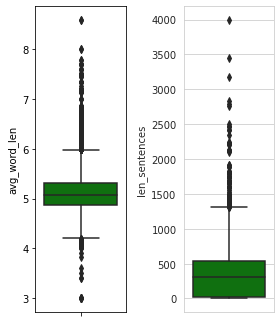

In [0]:
import seaborn as sns
l = ['avg_word_len', 'len_sentences']
number_of_columns = 2
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(2*number_of_columns,6*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df_nc[l[i]],color='green',orient='v')
    plt.tight_layout()

In [0]:
sum = 0
for x in range(1500, 4000, 1000 ):
    results = df_nc[df_nc['len_sentences'] > x]
    sum = sum + results['title '].size
    
amt = (sum/df_nc['title '].size)*100
print('Percentage of articles that have a word count of more than 1500 is {percent:.2f}%'.format(percent = amt))

Percentage of articles that have a word count of more than 1500 is 1.95%


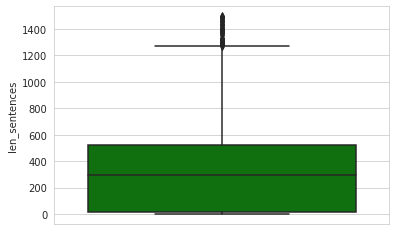

In [0]:
#articles of word count more than 1900 are thus being dropped
result_df = df_nc[df_nc['len_sentences']>=1500]

df_nc.drop(df_nc[df_nc['len_sentences'] >= 1500].index, inplace = True) 
sns.boxplot(df_nc['len_sentences'],color='green',orient='v')

In [0]:
df_nc.count()

title            2822
label            2822
avg_word_len     2822
len_sentences    2822
source           2822
text             2822
dtype: int64

In [0]:
df_nc.isna().sum()

title            0
label            0
avg_word_len     0
len_sentences    0
source           0
text             0
dtype: int64

In [0]:
#dropping all those features where text is null
df_nc = df_nc.dropna(how='any',axis=0) 

In [0]:
df_nc.count()

title            2822
label            2822
avg_word_len     2822
len_sentences    2822
source           2822
text             2822
dtype: int64


## Splitting the training and testing data to make the model

In [0]:
X = df_nc.drop('label', axis=1)
y = df_nc['label']

In [0]:
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, shuffle= True)

In [0]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [0]:
X1_train = list(X_train['text'])
X1_val = list(X_val['text'])

### Tokenisation

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_val = tokenizer.texts_to_sequences(X1_val)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 1500

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_val = pad_sequences(X1_val, padding='post', maxlen=maxlen)

### Generating Glove Embeddings

In [0]:
#prepare embeddings by GloVe
embedding_index = {}
f = open(os.path.join('/content/drive/My Drive/','glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs

f.close()
print('Found %s word vectors.' % len(embedding_index))

embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        #words not found in embedding index will be all-zero
        embedding_matrix[i] = embedding_vector

Found 400001 word vectors.


### Preparing variables for second and third input to the model

In [0]:
X2_train = X_train[['avg_word_len', 'len_sentences']]
X2_val = X_val[['avg_word_len', 'len_sentences']]

In [0]:
#adding this following line because X2_train was not a numpy array and wasn't training properly

X2_train = np.asarray(X2_train)
X2_val = np.asarray(X2_val)

### Model

In [0]:
def lstm_model(x_train, y_train, x_val, y_val, params):
  
  #for input one
  input_1 = Input(shape=(maxlen,))
  embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(input_1)

  LSTM_Layer_1 = LSTM(params['neurons'])(embedding_layer)

  #for input two
  input_2 = Input(shape=(2,))
  dense_layer_1 = Dense(params['dense'], activation=params['activation'])(input_2)
  dense_layer_2 = Dense(params['dense'], activation=params['activation'])(dense_layer_1)

  #concatanation
  concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_2])
  
  dense_layer_3 = Dense(params['dense'], activation=params['activation'])(concat_layer)

  #adding a dropout layer to reduce overfitting
  dense_layer_4 = Dropout(params['dropout'])(dense_layer_3)
  
  #output layer
  output = Dense(2, activation='softmax')(dense_layer_4)
  
  model = Model(inputs=[input_1, input_2], outputs=output)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', talos.utils.metrics.f1score])
  model.summary()


  #creating checkpoints to save the state of the model
  filepath="/content/drive/My Drive/LSTM_Model/model.{epoch:02d}-{val_loss:.2f}.h5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

  out = model.fit(x=x_train,
                      y=y_train, 
                      validation_data=[x_val, y_val],
                      callbacks=[checkpoint],
                      batch_size=params['batch_size'],
                      epochs=params['epochs'],
                      verbose=1)
  
  return out, model

In [0]:
p = { 'neurons' : [64, 128],
      'dense' : [10, 20],
     'activation':['relu', 'elu'],
     'dropout' : [0.1, 0.3],
     'batch_size' : [64, 128],
     'epochs' : [10, 30, 50]
     }


In [0]:
scan_object = talos.Scan(x=[X1_train, X2_train],
                         y=y_train,
                         x_val=[X1_val, X2_val],
                         y_val=y_val,
                         params=p,
                         model=lstm_model,
                         experiment_name="LSTM Model")

1856/1890 [============================>.] - ETA: 0s - loss: 0.5350 - acc: 0.7834 - f1score: 0.7834
Epoch 00004: val_acc did not improve from 0.80043
1890/1890 [==============================] - 8s 4ms/sample - loss: 0.5306 - acc: 0.7862 - f1score: 0.7887 - val_loss: 0.5019 - val_acc: 0.7908 - val_f1score: 0.7904

Epoch 00004: val_acc did not improve from 0.80043
1890/1890 [==============================] - 8s 4ms/sample - loss: 0.5306 - acc: 0.7862 - f1score: 0.7887 - val_loss: 0.5019 - val_acc: 0.7908 - val_f1score: 0.7904
Epoch 5/10
Epoch 5/10
1856/1890 [============================>.] - ETA: 0s - loss: 0.4723 - acc: 0.8168 - f1score: 0.8168
Epoch 00005: val_acc did not improve from 0.80043
1890/1890 [==============================] - 8s 4ms/sample - loss: 0.4697 - acc: 0.8180 - f1score: 0.8190 - val_loss: 0.4966 - val_acc: 0.7854 - val_f1score: 0.7884

Epoch 00005: val_acc did not improve from 0.80043
1890/1890 [==============================] - 8s 4ms/sample - loss: 0.4697 - acc: 





  1%|          | 1/96 [01:20<2:08:11, 80.97s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





  2%|▏         | 2/96 [03:05<2:17:59, 88.08s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





  3%|▎         | 3/96 [06:56<3:22:58, 130.96s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





  4%|▍         | 4/96 [12:02<4:41:12, 183.40s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





  5%|▌         | 5/96 [18:25<6:09:02, 243.32s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





  6%|▋         | 6/96 [26:50<8:02:31, 321.68s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





  7%|▋         | 7/96 [28:09<6:09:31, 249.11s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





  8%|▊         | 8/96 [29:53<5:01:20, 205.46s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





  9%|▉         | 9/96 [33:50<5:11:44, 215.00s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 10%|█         | 10/96 [38:58<5:47:51, 242.70s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 11%|█▏        | 11/96 [45:29<6:46:59, 287.29s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 12%|█▎        | 12/96 [53:55<8:14:18, 353.08s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 14%|█▎        | 13/96 [55:17<6:15:54, 271.74s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 15%|█▍        | 14/96 [57:03<5:03:04, 221.77s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 16%|█▌        | 15/96 [1:00:59<5:05:18, 226.16s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 17%|█▋        | 16/96 [1:06:07<5:34:26, 250.83s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 18%|█▊        | 17/96 [1:12:39<6:25:59, 293.16s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 19%|█▉        | 18/96 [1:21:07<7:44:56, 357.64s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 20%|█▉        | 19/96 [1:22:29<5:52:40, 274.82s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 21%|██        | 20/96 [1:24:14<4:43:46, 224.03s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 22%|██▏       | 21/96 [1:28:11<4:44:47, 227.83s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 23%|██▎       | 22/96 [1:33:17<5:09:54, 251.27s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 24%|██▍       | 23/96 [1:39:47<5:56:20, 292.88s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 25%|██▌       | 24/96 [1:48:19<7:10:20, 358.62s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 26%|██▌       | 25/96 [1:49:16<5:17:08, 268.00s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 27%|██▋       | 26/96 [1:50:32<4:05:33, 210.48s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 28%|██▊       | 27/96 [1:53:12<3:44:33, 195.26s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 29%|██▉       | 28/96 [1:56:50<3:49:13, 202.26s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 30%|███       | 29/96 [2:01:12<4:05:53, 220.19s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 31%|███▏      | 30/96 [2:07:14<4:48:58, 262.70s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 32%|███▏      | 31/96 [2:08:11<3:37:40, 200.92s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 33%|███▎      | 32/96 [2:09:27<2:54:30, 163.60s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 34%|███▍      | 33/96 [2:12:08<2:50:39, 162.53s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 35%|███▌      | 34/96 [2:15:47<3:05:35, 179.61s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 36%|███▋      | 35/96 [2:20:10<3:27:57, 204.55s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 38%|███▊      | 36/96 [2:26:10<4:11:22, 251.37s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 39%|███▊      | 37/96 [2:27:08<3:09:56, 193.17s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 40%|███▉      | 38/96 [2:28:24<2:32:45, 158.02s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 41%|████      | 39/96 [2:31:03<2:30:26, 158.35s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 42%|████▏     | 40/96 [2:34:41<2:44:28, 176.23s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 43%|████▎     | 41/96 [2:39:02<3:04:54, 201.72s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 44%|████▍     | 42/96 [2:45:10<3:46:20, 251.48s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 45%|████▍     | 43/96 [2:46:09<2:51:12, 193.82s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 46%|████▌     | 44/96 [2:47:26<2:17:39, 158.84s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 47%|████▋     | 45/96 [2:50:05<2:14:57, 158.77s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 48%|████▊     | 46/96 [2:53:42<2:27:02, 176.44s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 49%|████▉     | 47/96 [2:58:03<2:44:42, 201.69s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 50%|█████     | 48/96 [3:04:03<3:19:19, 249.16s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 51%|█████     | 49/96 [3:05:25<2:35:59, 199.13s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 52%|█████▏    | 50/96 [3:07:10<2:11:03, 170.94s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 53%|█████▎    | 51/96 [3:11:04<2:22:23, 189.85s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 54%|█████▍    | 52/96 [3:16:10<2:44:34, 224.43s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 55%|█████▌    | 53/96 [3:22:36<3:15:45, 273.14s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 56%|█████▋    | 54/96 [3:31:01<3:59:53, 342.71s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 57%|█████▋    | 55/96 [3:32:24<3:00:49, 264.63s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 58%|█████▊    | 56/96 [3:34:16<2:25:53, 218.84s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 59%|█████▉    | 57/96 [3:38:14<2:25:57, 224.54s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 60%|██████    | 58/96 [3:43:21<2:38:01, 249.50s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 61%|██████▏   | 59/96 [3:49:53<3:00:08, 292.12s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
______________________________________________________________________________________________





 62%|██████▎   | 60/96 [3:58:18<3:33:37, 356.05s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 64%|██████▎   | 61/96 [3:59:43<2:40:14, 274.69s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 65%|██████▍   | 62/96 [4:01:31<2:07:23, 224.80s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 66%|██████▌   | 63/96 [4:05:26<2:05:11, 227.63s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 67%|██████▋   | 64/96 [4:10:33<2:14:10, 251.56s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 68%|██████▊   | 65/96 [4:17:07<2:32:06, 294.39s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 69%|██████▉   | 66/96 [4:25:33<2:58:50, 357.68s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 70%|██████▉   | 67/96 [4:26:55<2:12:54, 274.97s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 71%|███████   | 68/96 [4:28:41<1:44:46, 224.51s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 72%|███████▏  | 69/96 [4:32:36<1:42:23, 227.54s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 73%|███████▎  | 70/96 [4:37:42<1:48:43, 250.91s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________





 74%|███████▍  | 71/96 [4:44:10<2:01:42, 292.08s/it]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    7521000     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           60          input_2[0][0]                    
______________________________________________________________________________________________